In [11]:
### **1. Environment Setup**

# Import necessary libraries
import os
import talib
import pandas as pd
import numpy as np
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Space
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import csv

In [12]:
# Constants
DATA_FILE = 'ethusd_hourly_klines.csv'
MODEL_PATH = 'ppo_trading_agent.zip'
TRADE_LOG_FILE = 'trade_logs.csv'
TENSORBOARD_LOG_DIR = './tensorboard_logs'

In [13]:
import pandas as pd
import talib
import numpy as np

# Load the raw ETH/USD dataset
DATA_FILE = 'ethusd_hourly_klines.csv'
df = pd.read_csv(DATA_FILE)

# Convert timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Calculate RSI and MACD
df['RSI'] = talib.RSI(df['close'], timeperiod=14)
macd, macd_signal, _ = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD'] = macd
df['MACD_signal'] = macd_signal

# Add more features
def add_features(df):
    df['Bollinger_upper'], df['Bollinger_middle'], df['Bollinger_lower'] = talib.BBANDS(
        df['close'], timeperiod=20, nbdevup=2, nbdevdn=2
    )
    df['ADX'] = talib.ADX(df['high'], df['low'], df['close'], timeperiod=14)
    df['ATR'] = talib.ATR(df['high'], df['low'], df['close'], timeperiod=14)
    df['rolling_mean'] = df['close'].rolling(window=5).mean()
    df['rolling_std'] = df['close'].rolling(window=5).std()
    df['price_change_1d'] = df['close'].pct_change()
    df['price_momentum'] = df['close'].diff(5)
    df['volatility'] = df['close'].rolling(10).std()
    df.dropna(inplace=True)
    return df

df_with_features = add_features(df)

# Define features for the RL agent
features = ['RSI', 'MACD', 'MACD_signal', 'ADX', 'ATR', 
            'rolling_mean', 'rolling_std', 'price_change_1d', 
            'price_momentum', 'volatility']


In [14]:
def create_states(df, window_size):
    states = []
    for i in range(window_size, len(df)):
        state = df.iloc[i - window_size:i][features].values
        states.append(state)
    return np.array(states)

# Create states using a sliding window
window_size = 30
states = create_states(df_with_features, window_size)

# Extract corresponding prices for rewards
prices = df_with_features['close'].values[window_size:]


In [30]:

import numpy as np

class TradingEnvironment(Env):
    def __init__(self, states, prices):
        super(TradingEnvironment, self).__init__()
        self.states = states
        self.prices = prices
        self.action_space = Discrete(3)  # 0: Hold, 1: Buy, 2: Sell
        self.observation_space = Box(
            low=-np.inf, high=np.inf, shape=(states.shape[1], states.shape[2]), dtype=np.float32
        )
        self.seed()  # Set a default seed
        self.reset()

    def seed(self, seed=None):
        np.random.seed(seed)

    def reset(self, seed=None, options=None):
        if seed is not None:
            self.seed(seed)  # Set the seed for reproducibility
        self.current_step = 0
        self.position = 0  # 0: Neutral, 1: Long, -1: Short
        self.previous_price = self.prices[self.current_step]
        self.total_reward = 0
        obs = self.states[self.current_step].astype(np.float32)  # Ensure dtype is float32
        info = {}  # Additional metadata can go here
        return obs, info

    def step(self, action):
        current_price = self.prices[self.current_step]
        reward = self._calculate_reward(action, current_price)
        self.total_reward += reward

        self.current_step += 1
        terminated = self.current_step >= len(self.states) - 1
        truncated = False  # You can add a custom condition for truncation if needed
        obs = self.states[self.current_step].astype(np.float32) if not terminated else None  # Ensure dtype is float32
        self.previous_price = current_price
        info = {"total_reward": self.total_reward}  # Add relevant information here
        return obs, reward, terminated, truncated, info

    def _calculate_reward(self, action, current_price):
        transaction_cost = 0.001
        reward = 0

        if action == 1:  # Buy
            if self.position == 0:  # Opening a long position
                reward = -transaction_cost
                self.position = 1
            elif self.position == -1:  # Closing a short position
                reward = self.previous_price - current_price - transaction_cost
                self.position = 0

        elif action == 2:  # Sell
            if self.position == 0:  # Opening a short position
                reward = -transaction_cost
                self.position = -1
            elif self.position == 1:  # Closing a long position
                reward = current_price - self.previous_price - transaction_cost
                self.position = 0

        # No reward for Hold
        return reward


In [31]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv

# Initialize the environment
env = TradingEnvironment(states, prices)

# Validate the environment (optional but recommended)
check_env(env)

# Wrap the environment with DummyVecEnv
vec_env = DummyVecEnv([lambda: env])

# Initialize the PPO model
model = PPO("MlpPolicy", vec_env, verbose=1)

# Train the model
model.learn(total_timesteps=100000)

# Save the trained model
model.save("ppo_trading_agent")

print("Training complete. Model saved as 'ppo_trading_agent'.")


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 4426 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 2551        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011372289 |
|    clip_fraction        | 0.0292      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.000265   |
|    learning_rate        | 0.0003      |
|    loss                 | 317         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00149    |
|    value_loss           | 866         |
-----------------------------------------
-----------------

Total Reward: -2295.138999999946
Actions Taken: [array(1), array(1), array(1), array(1), array(1), array(0), array(0), array(0), array(0), array(1), array(1), array(1), array(1), array(1), array(0), array(0), array(1), array(1), array(2), array(0), array(0), array(0), array(2), array(1), array(0), array(0), array(1), array(1), array(1), array(2), array(1), array(0), array(2), array(0), array(2), array(2), array(0), array(0), array(1), array(2), array(1), array(1), array(1), array(1), array(1), array(0), array(0), array(0), array(1), array(0), array(1), array(0), array(1), array(1), array(1), array(1), array(0), array(0), array(1), array(1), array(2), array(1), array(1), array(0), array(1), array(1), array(1), array(0), array(1), array(2), array(2), array(0), array(0), array(2), array(0), array(0), array(1), array(2), array(0), array(1), array(1), array(1), array(0), array(0), array(0), array(1), array(2), array(1), array(0), array(2), array(1), array(1), array(0), array(1), array(2), a

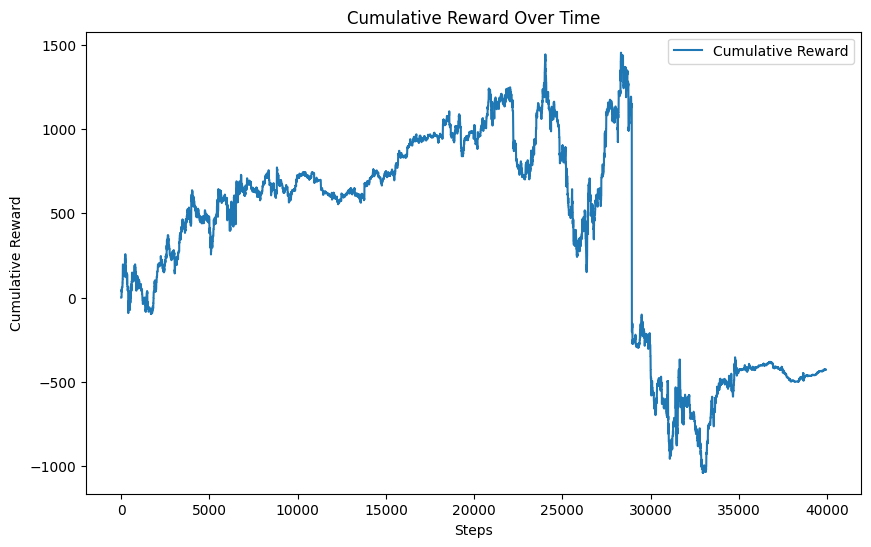

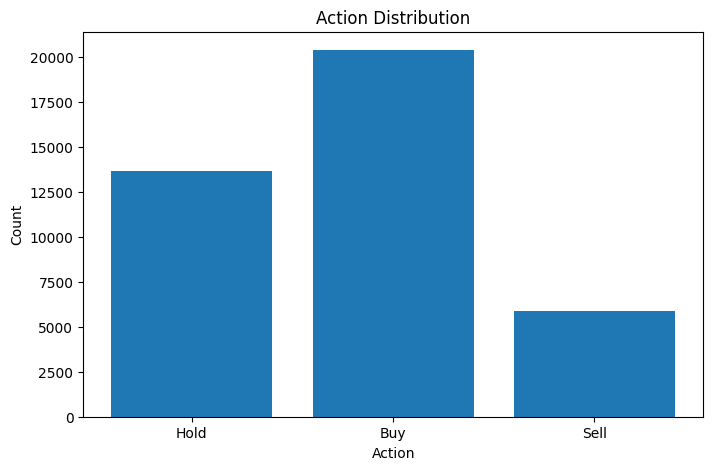

In [33]:
from stable_baselines3 import PPO

# Load the trained model
model = PPO.load("ppo_trading_agent")

# Reset the environment
obs, info = env.reset()
done = False
total_reward = 0
actions_taken = []

# Run the agent in the environment
while not done:
    # Predict the action
    action, _ = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    actions_taken.append(action)
    done = terminated or truncated  # Check if the episode is over

print(f"Total Reward: {total_reward}")
print(f"Actions Taken: {actions_taken}")

import matplotlib.pyplot as plt

# Reset the environment
obs, info = env.reset()
done = False
total_reward = 0
rewards = []
cumulative_rewards = []

# Run the agent in the environment
while not done:
    action, _ = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    rewards.append(reward)
    cumulative_rewards.append(total_reward)
    done = terminated or truncated

# Plot cumulative rewards
plt.figure(figsize=(10, 6))
plt.plot(cumulative_rewards, label='Cumulative Reward')
plt.title("Cumulative Reward Over Time")
plt.xlabel("Steps")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.show()

import numpy as np

# Count the actions
actions, counts = np.unique(actions_taken, return_counts=True)

# Plot the action distribution
plt.figure(figsize=(8, 5))
plt.bar(actions, counts, tick_label=["Hold", "Buy", "Sell"])
plt.title("Action Distribution")
plt.xlabel("Action")
plt.ylabel("Count")
plt.show()



ValueError: x and y must be the same size

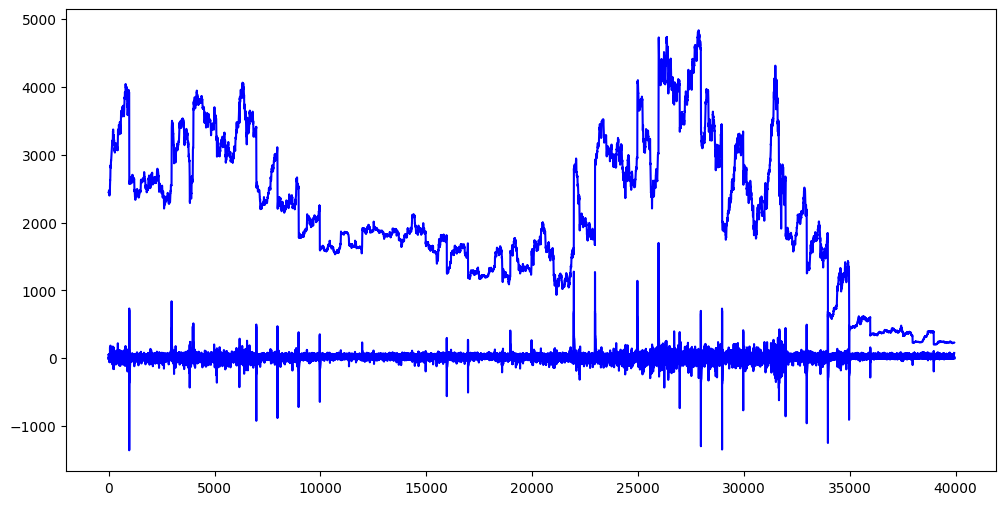

In [35]:
# Reset the environment
obs, info = env.reset()
done = False
actions = []
rsi_values = []
timestamps = []

# Extract RSI values and actions during evaluation
while not done:
    action, _ = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    actions.append(action)
    rsi_values.append(env.states[env.current_step - 1, features.index("RSI")])  # Extract RSI value
    timestamps.append(env.current_step)
    done = terminated or truncated

# Convert actions to markers
action_markers = ["Hold" if a == 0 else "Buy" if a == 1 else "Sell" for a in actions]

# Plot RSI and actions
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot RSI
plt.plot(timestamps, rsi_values, label="RSI", color="blue")

# Overlay actions
for i, (timestamp, rsi, marker) in enumerate(zip(timestamps, rsi_values, action_markers)):
    if marker == "Buy":
        plt.scatter(timestamp, rsi, color="green", label="Buy" if i == 0 else "", marker="^")
    elif marker == "Sell":
        plt.scatter(timestamp, rsi, color="red", label="Sell" if i == 0 else "", marker="v")

# Add labels and legend
plt.axhline(30, color="green", linestyle="--", label="RSI Oversold (30)")
plt.axhline(70, color="red", linestyle="--", label="RSI Overbought (70)")
plt.title("Actions in Relation to RSI")
plt.xlabel("Steps")
plt.ylabel("RSI")
plt.legend()
plt.show()
